In [30]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 20 14:57:19 2017

@author: Rodrigo Azevedo

Trabalho de Busca e Recuperação da Informação - 2017.2
Universidade Federal do Rio de Janeiro - PESC

"""
import csv
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#autolabel from
#http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/
def autolabel(rects, mes):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f%s' % (float(height), mes),
                ha='center', va='bottom')

files_read = '../results_porter/esperados.csv'
models = ['porter', 'no_porter']
#esperados = []
relevants = {}
relevances = {}
retrieveds = {'porter' : {}, 'no_porter': {}}

# ==============================================================
# obtem os itens relevantes de cada consulta
with open(files_read, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
        if len(row):
            try:
                if int(row[0]) in relevants:
                    relevants[int(row[0])].append(int(row[1]))
                else:
                    relevants[int(row[0])] = [int(row[1])]
                if int(row[0]) not in relevances:
                    relevances[int(row[0])] = {}
                relevances[int(row[0])][int(row[1])] = int(row[2])
            except:
                pass

# ==============================================================
# obtem os itens retornados em ordem de cada consulta       
for model in models:
    files_read = '../results_'+ model +'/busca_result.csv'
    with open(files_read, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        for row in reader:
            if len(row):
                try:
                    rec = []
                    row1 = ast.literal_eval(row[1])
                    for r in row1:
                        rec.append(r[1]) # returns all of them
                    retrieveds[model][int(row[0])] = rec
                except:
                    pass
                
n_queries = len(relevants)
n_documents = len(retrieveds['porter'][1])

In [2]:
# ==============================================================
# calcula precision e recall para cada query      
precisions = {'porter' : np.zeros((n_queries, n_documents)), 'no_porter': np.zeros((n_queries, n_documents))}
recalls = {'porter' : np.zeros((n_queries, n_documents)), 'no_porter': np.zeros((n_queries, n_documents))} 
     
for model in models:
    m = 0
    for key, value in retrieveds[model].items():
        rel = len(relevants[key])
        rel_retrieved = 0
        for k in range(len(value)):
            if value[k] in relevants[key]:
                rel_retrieved += 1
            precisions[model][m][k] = rel_retrieved / (1.0*(k + 1))
            recalls[model][m][k] = rel_retrieved / (1.0*rel)
        m += 1

In [3]:
# ==============================================================
# calculado o maximo a direita nos precisions
for model in models:
    for i in range(len(precisions[model])):
        for j in range(len(precisions[model][i])-1, 0, -1):
            if precisions[model][i][j] > precisions[model][i][j-1]:
                precisions[model][i][j-1] = precisions[model][i][j]

# ==============================================================
# calculos interpolado nos 11 pontos  
interpolated_prec_recs_each =  {'porter' : np.zeros((n_queries, 11)), 'no_porter': np.zeros((n_queries, 11))}
interpolated_prec_recs =  {'porter' : np.zeros(11), 'no_porter': np.zeros(11)}

for model in models:
    for q in range(n_queries):
        prec = precisions[model][q]
        rec = recalls[model][q]
        for recall_in_level in range(0, 11):
            prec_at = 0
            for k in range(n_documents):
                if recall_in_level <= rec[k] * 10:
                    prec_at = max(prec_at, prec[k])
            interpolated_prec_recs_each[model][q][recall_in_level] = prec_at
    interpolated_prec_recs[model] = np.mean(interpolated_prec_recs_each[model], axis = 0)

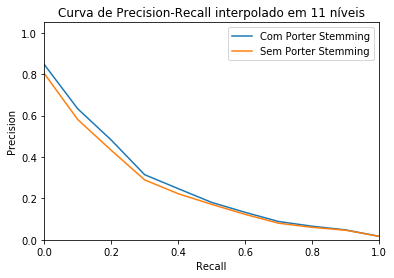

In [4]:
# ==============================================================
# plot 11 interpolated precision recall curve
rec_x = np.arange(0, 1.1, 0.1)

for model in models:
    label = 'Com Porter Stemming' if model == 'porter' else 'Sem Porter Stemming'
    plt.plot(rec_x, interpolated_prec_recs[model], label=label)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Curva de Precision-Recall interpolado em 11 níveis")
plt.legend(loc='upper right')
plt.show()

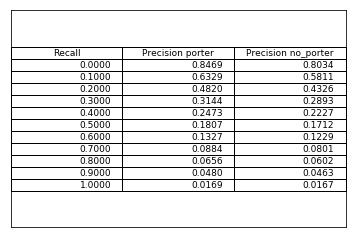

In [11]:
# ==============================================================
# plot table
cell_0 = np.array(['%1.4f' % (x) for x in rec_x])
cell_1 = np.array(['%1.4f' % (x) for x in interpolated_prec_recs[models[0]]])
cell_2 = np.array(['%1.4f' % (x) for x in interpolated_prec_recs[models[1]]])
cell_text = np.column_stack((cell_0, cell_1, cell_2))
fig, ax = plt.subplots()
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
collabel=('Recall', 'Precision '+ models[0], 'Precision '+ models[1])
ax.table(cellText=cell_text, colLabels=collabel, loc='center')
plt.show()

In [12]:

# ==============================================================
# f1 score
f1s =  {'porter' : None, 'no_porter': None}
for model in models:
    f1 = (2 * precisions[model] * recalls[model]) / (precisions[model] + recalls[model])
    f1s[model] = f1

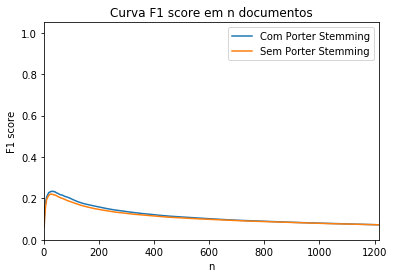

In [13]:
# ==============================================================
# plot f1 scores
rec_x = np.arange(1, n_documents+1)

for model in models:
    label = 'Com Porter Stemming' if model == 'porter' else 'Sem Porter Stemming'
    plt.plot(rec_x, np.mean(f1s[model], axis=0), label=label)

plt.xlim([1, n_documents+1])
plt.ylim([0.0, 1.05])
plt.xlabel('n')
plt.ylabel('F1 score')
plt.title("Curva F1 score em n documentos")
plt.legend(loc='upper right')
plt.show()

In [14]:
# MAP
maps =  {'porter' : 0.0, 'no_porter': 0.0}
for model in models:
    maps[model] = np.mean(precisions[model])

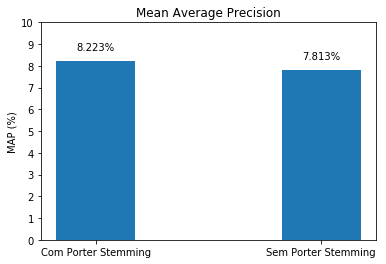

In [16]:
# MAP plot
ind = np.arange(len(models))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) 
map_p = np.array([maps[models[0]], maps[models[1]]]) * 100

rect = plt.bar(ind, map_p, width, align='center')
plt.ylabel('MAP (%)')
plt.title('Mean Average Precision')
plt.xticks(ind, ('Com Porter Stemming', 'Sem Porter Stemming'))
autolabel(rect, '%')
plt.yticks(np.arange(0, 11, 1))
plt.show()

In [17]:
# p@10 e p@5
pat10 =  {'porter' : 0.0, 'no_porter': 0.0}
pat5 =  {'porter' : 0.0, 'no_porter': 0.0}
for model in models:
    pat10[model] = np.mean(precisions[model][:, 9])
    pat5[model] = np.mean(precisions[model][:, 4])

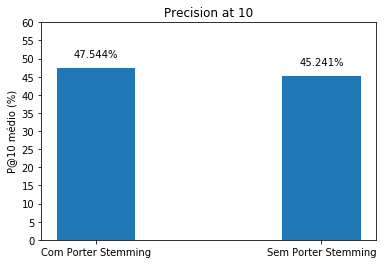

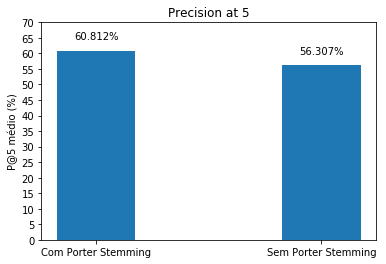

In [20]:
# p@10 e p@5 plot
ind = np.arange(len(models))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) 
pat_p = np.array([pat10[models[0]], pat10[models[1]]]) * 100

rect = plt.bar(ind, pat_p, width, align='center')
plt.ylabel('P@10 médio (%)')
plt.title('Precision at 10')
plt.xticks(ind, ('Com Porter Stemming', 'Sem Porter Stemming'))
autolabel(rect, '%')
plt.yticks(np.arange(0, 61, 5))
plt.show()

ind = np.arange(len(models))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) 
pat_p = np.array([pat5[models[0]], pat5[models[1]]]) * 100

rect = plt.bar(ind, pat_p, width, align='center')
plt.ylabel('P@5 médio (%)')
plt.title('Precision at 5')
plt.xticks(ind, ('Com Porter Stemming', 'Sem Porter Stemming'))
autolabel(rect, '%')
plt.yticks(np.arange(0, 71, 5))
plt.show()

In [21]:
# mean reciprocal rank
mrr = {'porter' : np.zeros((n_queries)), 'no_porter': np.zeros((n_queries))}
   
for model in models:
    m = 0
    for key, value in retrieveds[model].items():
        for k in range(len(value)):
            if value[k] in relevants[key]:
                mrr[model][m] = 1.0 / (k + 1)
                break
        m += 1
    mrr[model] = np.mean(mrr[model])

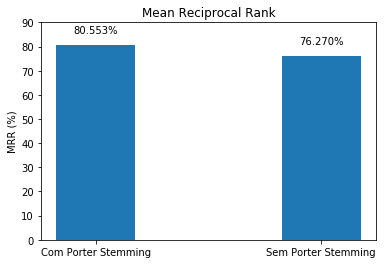

In [22]:
# plot mean reciprocal rank
ind = np.arange(len(models))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) 
mrr_p = np.array([mrr[models[0]], mrr[models[1]]]) * 100

rect = plt.bar(ind, mrr_p, width, align='center')
plt.ylabel('MRR (%)')
plt.title('Mean Reciprocal Rank')
plt.xticks(ind, ('Com Porter Stemming', 'Sem Porter Stemming'))
autolabel(rect, '%')
plt.yticks(np.arange(0, 91, 10))
plt.show()

In [24]:
# RP A/B
r_precisions = {'porter' : np.zeros((n_queries)), 'no_porter': np.zeros((n_queries))}

for model in models:
    ret = list(retrieveds[model])
    for i in range(len(ret)):
        query_id = ret[i]
        rel_q = relevants[query_id]
        n_rel_q = len(rel_q)
        ret_q = retrieveds[model][query_id][:n_rel_q]
        r = set(ret_q).intersection(set(rel_q))
        r_precisions[model][i] = len(r) / (1.0 * n_rel_q)
        
# porter - no_porter
r_precisions_a_b = r_precisions['porter'] - r_precisions['no_porter']
        

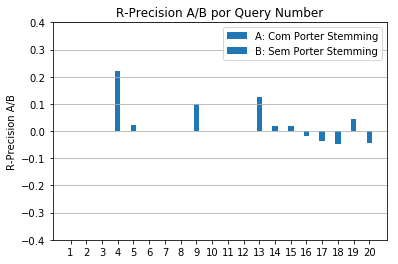

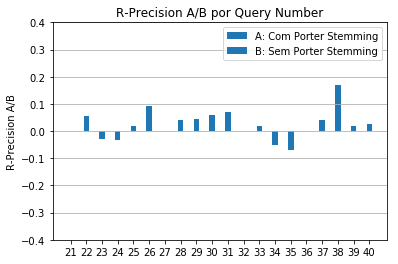

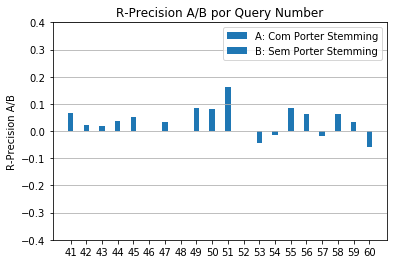

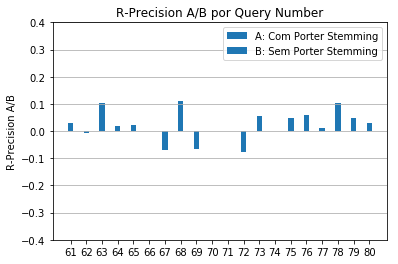

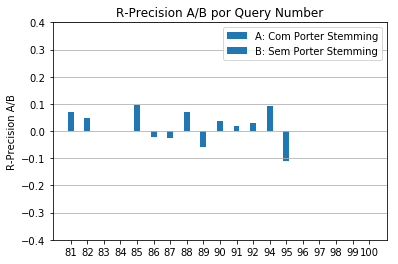

In [25]:
# plot RP A/B
for n_start in range(0, 100, 20):
    n_q = 20
    if n_start + n_q > n_queries:
        n_q = n_queries - n_start
    ind = np.arange(n_q)    # the x locations for the groups
    x_st = (list(retrieveds['porter']))[n_start:(n_start+n_q)]
    width = 0.35       # the width of the bars: can also be len(x) 
    
    a_patch = mpatches.Patch(label='A: Com Porter Stemming')
    b_patch = mpatches.Patch(label='B: Sem Porter Stemming')
    plt.legend(handles=[a_patch, b_patch])
    plt.gca().yaxis.grid()
    rect = plt.bar(ind, r_precisions_a_b[n_start:(n_start+n_q)], width, align='center')
    plt.ylabel('R-Precision A/B')
    plt.title('R-Precision A/B por Query Number')
    plt.xticks(ind, x_st)
    plt.yticks(np.arange(-0.4, 0.5, 0.1))
    plt.show()

In [26]:
# normalized DCG
ndcg = {'porter' : np.zeros((n_queries, n_documents)), 'no_porter': np.zeros((n_queries, n_documents))}
dcg = {'porter' : np.zeros((n_queries, n_documents)), 'no_porter': np.zeros((n_queries, n_documents))}
idcg = {'porter' : np.zeros((n_queries, n_documents)), 'no_porter': np.zeros((n_queries, n_documents))}

for model in models:
    m = 0
    for key, value in retrieveds[model].items():
        # calcula cdg
        for i in range(len(value)):
            cg_last = 0.0 if i == 0 else dcg[model][m][i-1]
            d_log2 = np.log2(i + 1) if (i + 1) > 1 else 1.0
            g = relevances[key][value[i]] if value[i] in relevances[key] else 0.0
            dcg[model][m][i] = g/d_log2 + cg_last
        # calcula idcg
        isort = sorted([value for key, value in relevances[key].items()], reverse=True)
        for i in range(n_documents):
            icg_last = 0.0 if i == 0 else idcg[model][m][i-1]
            d_log2 = np.log2(i + 1) if (i + 1) > 1 else 1.0
            ig = isort[i] if i < len(isort) else 0.0
            idcg[model][m][i] = ig/d_log2 + icg_last
        m += 1
    dcg[model] = np.mean(dcg[model], axis = 0)
    idcg[model] = np.mean(idcg[model], axis = 0)
    ndcg[model] = dcg[model] / idcg[model]

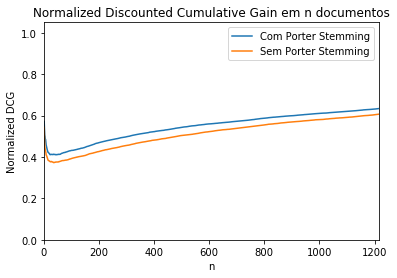

In [27]:
# plot ndcg
rec_x = np.arange(1, n_documents+1)

for model in models:
    label = 'Com Porter Stemming' if model == 'porter' else 'Sem Porter Stemming'
    plt.plot(rec_x, ndcg[model], label=label)

plt.xlim([1, n_documents+1])
plt.ylim([0.0, 1.05])
plt.xlabel('n')
plt.ylabel('Normalized DCG')
plt.title("Normalized Discounted Cumulative Gain em n documentos")
plt.legend(loc='upper right')
plt.show()

In [28]:
# BPREF
bpref = {'porter' : np.zeros((n_queries, n_documents)), 'no_porter': np.zeros((n_queries, n_documents))}

for model in models:
    ret = list(retrieveds['porter'])
    for i in range(len(ret)):
        query_id = ret[i]
        rel_q = relevants[query_id]
        n_rel_q = len(rel_q)
        ret_q = retrieveds[model][query_id]
        non_relevant_count = 0
        last = 0
        for j in range(len(ret_q)):
            if ret_q[j] in rel_q:
                last += 1.0/n_rel_q * (1-non_relevant_count/(1.0*n_rel_q))
            else:
                non_relevant_count += 1
            bpref[model][i][j] = last
    bpref[model] = np.mean(bpref[model], axis = 0)

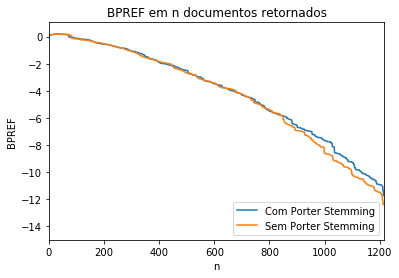

In [29]:
# plot BPREF
rec_x = np.arange(1, n_documents+1)

for model in models:
    label = 'Com Porter Stemming' if model == 'porter' else 'Sem Porter Stemming'
    plt.plot(rec_x, bpref[model], label=label)

plt.xlim([1, n_documents+1])
plt.ylim([-15.0, 1.05])
plt.xlabel('n')
plt.ylabel('BPREF')
plt.title("BPREF em n documentos retornados")
plt.legend(loc='lower right')
plt.show()